# Make observed data from synthetic data

NOTE: This Jupyter Notebook should be run in /project_name/source_name

The aim is to calculate the kernels. To do this, observed correlation data is necessary. This script converts modelled data to observed data.

In [1]:
import os
import glob
import shutil
import obspy
import pandas as pd
from obspy import read
from obspy.geodetics import gps2dist_azimuth
import numpy as np
import sys
from glob import glob
from obspy.core import AttribDict


In [2]:
# For dataless conversion set it to true
dataless = True
corr_filt_sectionplot = True

# Get Project name
project_name = os.path.basename(os.path.dirname(os.getcwd()))
# print(project_name)

# first get paths to different files
path_stations = ('../stationlist.csv')
path_model = ('./step_0/corr/')
path_obs = ('./observed_correlations/')


# ABOVE CAN BE CHANGED FOR PYTHON SCRIPT TO RUN WITH INPUT ARGUMENTS, see Laura's code

# delete files in observed_correlations folder if necessary
for files in glob(os.path.join(path_obs,'*')):
    os.remove(files)

# copy files from the synthetic correlations to the observed correlations '/Source_1/observed_correlations/'
for files in glob(os.path.join(path_model,'*.sac')):
        shutil.copy(files,path_obs)
        print 'Copied:',files
        # below for error analysis
        #print os.path.basename(files).split('.')[3]#.split('--')[0]
        #print os.path.basename(files).split('--')[1]#.split('.')[3]

Copied: ./step_0/corr/CH.BOURR..MXZ--CH.FUORN..MXZ.sac
Copied: ./step_0/corr/CH.FIESA..MXZ--CH.FUORN..MXZ.sac
Copied: ./step_0/corr/CH.FIESA..MXZ--CH.SENIN..MXZ.sac
Copied: ./step_0/corr/CH.FUORN..MXZ--CH.SENIN..MXZ.sac
Copied: ./step_0/corr/CH.BOURR..MXZ--CH.SENIN..MXZ.sac
Copied: ./step_0/corr/CH.BOURR..MXZ--CH.FIESA..MXZ.sac
Copied: ./step_0/corr/CH.LIENZ..MXZ--CH.SENIN..MXZ.sac
Copied: ./step_0/corr/CH.BOURR..MXZ--CH.LIENZ..MXZ.sac
Copied: ./step_0/corr/CH.FUORN..MXZ--CH.LIENZ..MXZ.sac
Copied: ./step_0/corr/CH.FIESA..MXZ--CH.LIENZ..MXZ.sac


In [3]:
# Rename files as noisi expects different filename

for filename in glob(os.path.join(path_obs,'*.sac*')):
    # make sure they're not renamed if they've already been renamed
    if filename.endswith(project_name + '.sac'): 
        break
    else:
        # get filename without extension
        filename_wo_ext = os.path.splitext(filename)[0]
        ext = os.path.splitext(filename)[1]
        # change -- to . and add project name and extension
        filename_1 = filename_wo_ext.replace('--','.')
        filename_2 = filename_1 + '.' + project_name + ext
        # rename the file
        os.rename(filename,filename_2)
        print 'Renamed:', filename_2

# For error analysis
#for filename in glob(os.path.join(path_obs,'*.sac*')):
#    print filename
#    print os.path.basename(filename).split('.')[3]#.split('--')[0]
#    print os.path.basename(filename).split('.')[7]#.split('.')[3]

Renamed: ./observed_correlations/CH.BOURR..MXZ.CH.FUORN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.FIESA..MXZ.CH.FUORN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.FIESA..MXZ.CH.SENIN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.FUORN..MXZ.CH.SENIN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.BOURR..MXZ.CH.SENIN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.BOURR..MXZ.CH.FIESA..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.LIENZ..MXZ.CH.SENIN..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.BOURR..MXZ.CH.LIENZ..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.FUORN..MXZ.CH.LIENZ..MXZ.SwissGrid.sac
Renamed: ./observed_correlations/CH.FIESA..MXZ.CH.LIENZ..MXZ.SwissGrid.sac


In [4]:
# Check metadata in observed_correlations folder
# load the correlations into a file with obspy
ext = '*.sac'
corrs_path_obs = os.path.join(path_obs,ext) # get all .sac files in directory
st = obspy.read(corrs_path_obs) # load all into one stream
# print(st)
print st[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:06:40.000000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 401
           calib: 1.0
         _format: SAC
             sac: AttribDict({u'nzsec': 0, u'iftype': 1, u'e': 400.0, u'nzyear': 1970, u'nvhdr': 6, u'depmen': -1.894364e-17, u'nzjday': 1, u'nzmin': 0, u'iztype': 9, u'depmax': 8.503677e-15, u'lovrok': 1, u'nzhour': 0, u'scale': 1.0, u'delta': 1.0, u'npts': 401, u'lpspol': 1, u'lcalda': 0, u'b': 0.0, u'depmin': -6.6474527e-15, u'nzmsec': 0, u'leven': 1})


# Laura's code: assign_geodata.py

Changed the indir and metafile input so it would run in this notebook. 
For meta = .. engine = 'python' has been added.

In [5]:
#indir = sys.argv[1]
#metafile = sys.argv[2]
indir = path_obs
metafile = '../stationlist.csv'


print(indir)
traces = glob(indir+'/*.SAC')
traces.extend(glob(indir+'/*.sac'))
print('Found traces:\n')
print(traces[0])
print('...to...')
print(traces[-1])
print('\n')
print('Assign geographical information.\n')
print('Number of traces:')
print(np.size(traces))
print('\n')

meta = pd.read_csv(metafile, engine='python')

for t in traces:
    tr = read(t)
    sta1 = os.path.basename(t).split('.')[1]
    try:
        sta2 = os.path.basename(t).split('--')[1].split('.')[1]
    except IndexError:
        sta2 = os.path.basename(t).split('.')[5]
    print(sta1,sta2)
    lat1 = float(meta[meta['sta']==sta1].iloc[0]['lat'])
    lat2 = float(meta[meta['sta']==sta2].iloc[0]['lat'])
    lon1 = float(meta[meta['sta']==sta1].iloc[0]['lon'])
    lon2 = float(meta[meta['sta']==sta2].iloc[0]['lon'])
    print(lat1,lon1,lat2,lon2)
    
    tr[0].stats.network = os.path.basename(t).split('.')[0]
    tr[0].stats.station = sta1
    tr[0].stats.location = ''
    tr[0].stats.channel = os.path.basename(t).split('.')[3] #os.path.basename(t).split('.')[3].split('--')[0]
    tr[0].stats.sac.stlo = lon1
    tr[0].stats.sac.stla = lat1
    tr[0].stats.sac.evlo = lon2
    tr[0].stats.sac.evla = lat2
    tr[0].stats.sac.kuser0 = meta[meta['sta']==sta2].iloc[0]['net']
    
    tr[0].stats.sac.kevnm = sta2
    tr[0].stats.sac.kuser1 = ''
    try:
        tr[0].stats.sac.kuser2 = os.path.basename(t).split('.')[7] #os.path.basename(t).split('--')[1].split('.')[3]
    except IndexError:
        sta2 = os.path.basename(t).split('.')[7]
    tr[0].stats.sac.user0 = 100.   
    #print lat1 > -90.
    #print lat1 < 90.
    #print type(lat1)
    #print(float(lat1))
    #print lat1,lon1,lat2,lon2
    
    geoinf = gps2dist_azimuth(lat1,lon1,lat2,lon2)
    tr[0].stats.sac.dist = geoinf[0]
    tr[0].stats.sac.az = geoinf[1]
    tr[0].stats.sac.baz = geoinf[2]
    tr[0].stats['distance'] = geoinf[0]   # add stats.distance for section plot
    #print tr[0].stats.keys()

    tr.write(t,format='SAC')
    #tr.plot()
    
    #tr.plot(type='section',scale=150)
    #print(tr[0].stats.distance)


    


./observed_correlations/
Found traces:

./observed_correlations/CH.FIESA..MXZ.CH.LIENZ..MXZ.SwissGrid.sac
...to...
./observed_correlations/CH.BOURR..MXZ.CH.LIENZ..MXZ.SwissGrid.sac


Assign geographical information.

Number of traces:
10


('FIESA', 'LIENZ')
(46.43527, 8.110430000000001, 47.2946, 9.4927)
('FUORN', 'SENIN')
(46.62022, 10.26352, 46.36335, 7.2993)
('BOURR', 'SENIN')
(47.395, 7.2313, 46.36335, 7.2993)
('BOURR', 'FUORN')
(47.395, 7.2313, 46.62022, 10.26352)
('BOURR', 'FIESA')
(47.395, 7.2313, 46.43527, 8.110430000000001)
('FIESA', 'FUORN')
(46.43527, 8.110430000000001, 46.62022, 10.26352)
('LIENZ', 'SENIN')
(47.2946, 9.4927, 46.36335, 7.2993)
('FIESA', 'SENIN')
(46.43527, 8.110430000000001, 46.36335, 7.2993)
('FUORN', 'LIENZ')
(46.62022, 10.26352, 47.2946, 9.4927)
('BOURR', 'LIENZ')
(47.395, 7.2313, 47.2946, 9.4927)


In [6]:
print st[0].stats.sac.keys()

[u'nzsec', u'iftype', u'e', u'nzyear', u'nvhdr', u'depmen', u'nzjday', u'nzmin', u'iztype', u'depmax', u'lovrok', u'nzhour', u'scale', u'delta', u'npts', u'lpspol', u'lcalda', u'b', u'depmin', u'nzmsec', u'leven']


# Back to my code

         network: CH
         station: BOURR
        location: 
         channel: MXZ
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:06:40.000000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 401
           calib: 1.0
         _format: SAC
             sac: AttribDict({u'dist': 125966.625, u'nzyear': 1970, u'user0': 100.0, u'nzjday': 1, u'iztype': 9, u'evla': 46.43527, u'knetwk': u'CH', u'az': 147.5624, u'evlo': 8.11043, u'scale': 1.0, u'nvhdr': 6, u'kuser0': u'CH', u'kuser1': u'', u'kuser2': u'MXZ', u'depmin': -6.6474527e-15, u'kcmpnm': u'MXZ', u'nzsec': 0, u'kevnm': u'FIESA           ', u'depmen': -1.8943627e-17, u'depmax': 8.503677e-15, u'iftype': 1, u'delta': 1.0, u'lcalda': 0, u'e': 400.0, u'nzmsec': 0, u'lpspol': 1, u'b': 0.0, u'stla': 47.395, u'leven': 1, u'stlo': 7.2313, u'baz': 328.2045, u'kstnm': u'BOURR', u'nzmin': 0, u'lovrok': 1, u'npts': 401, u'nzhour': 0})


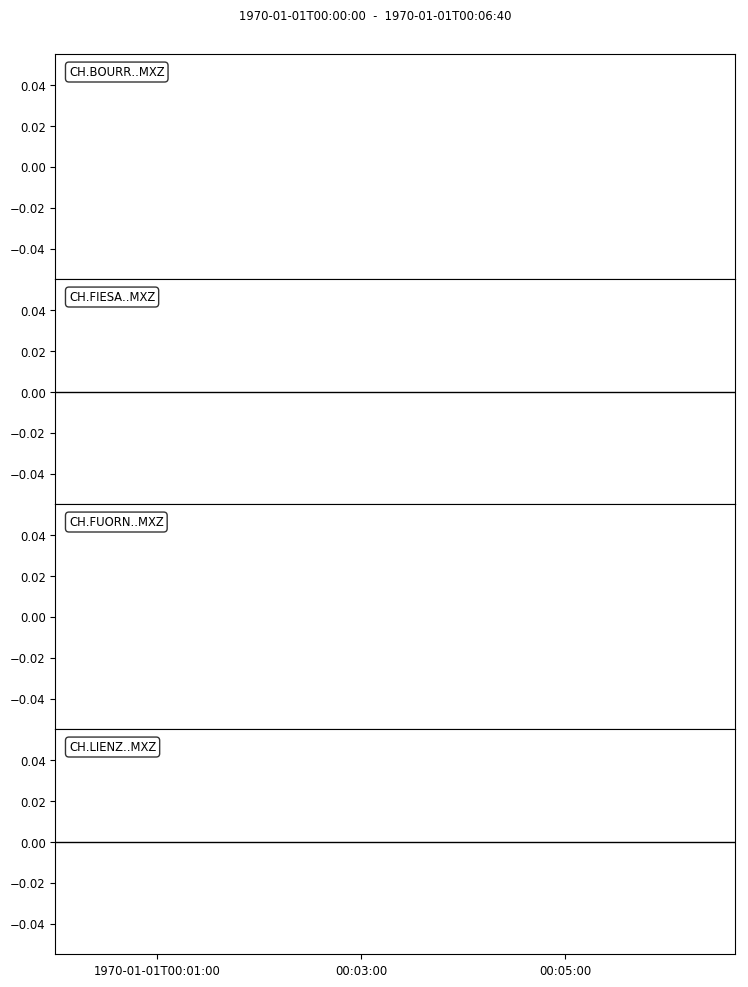

In [9]:
# Check the metadata again
ext = '*.sac'
corrs_path_obs = os.path.join(path_obs,ext) # get all .sac files in directory
st = obspy.read(corrs_path_obs) # load all into one stream
#print(st)
print st[0].stats 
#print st[0].stats.distance
st.plot()

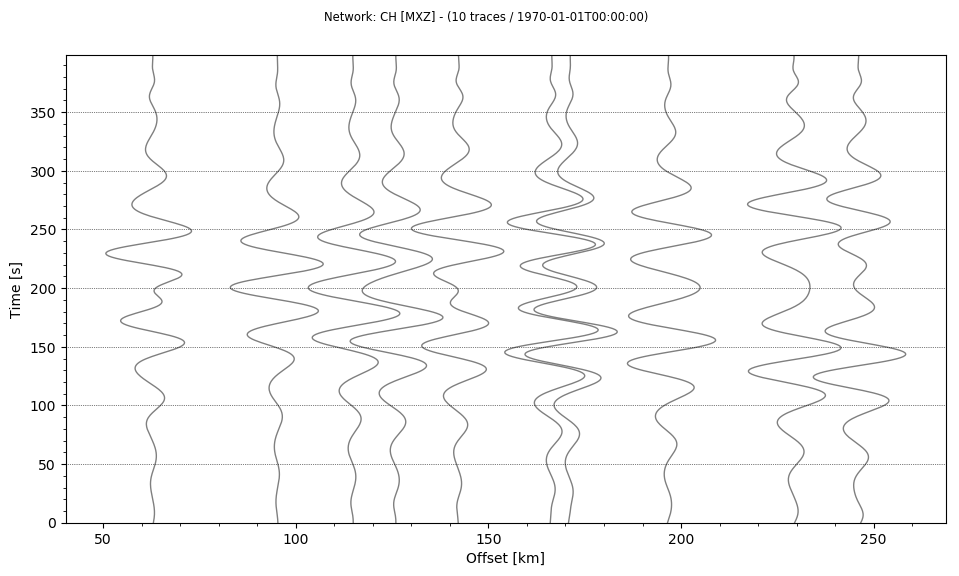

In [8]:
# Plot to see correlations
if corr_filt_sectionplot: 
    st1 = obspy.Stream()
    st2 = obspy.Stream()

    for tr in traces:
        t = read(tr)
        t[0].stats.distance = t[0].stats.sac.dist
        #print t[0].stats.distance
        t_filt = t
        t_filt.filter('bandpass',freqmin=0.02,freqmax=0.05,zerophase = True)
        #t_filt.plot()
        #t_filt.plot(type='section')
        st1 += t_filt
        st2 += t

    st1.plot(type='section')
    #st1.spectrogram(log=True,wlen=50)
    #st2.plot(type='section')


# Option 1: dataless measurement

All the traces are changed to 1 as if the measurement is 0. 
That means: synthetic data is compared with 

10 Trace(s) in Stream:
CH.BOURR..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.BOURR..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.BOURR..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.BOURR..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.FIESA..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.FIESA..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.FIESA..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.FUORN..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.FUORN..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples
CH.LIENZ..MXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:06:40.000000Z | 1.0 Hz, 401 samples


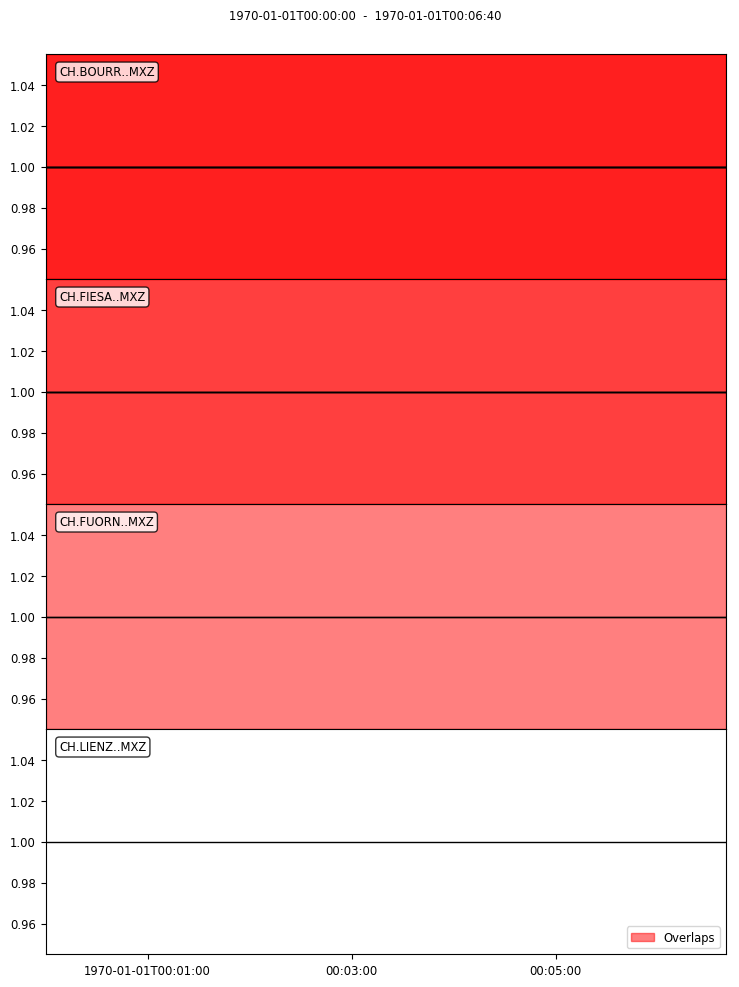

In [39]:
# Change all trace.data to 1 if dataless = true or leave
print(st)

if dataless:
    for trace in st:
        size = np.size(trace.data)
        trace.data = np.ones(size)
else:
    pass

st.plot(show=True)

# Option 2: compare it to a different source distribution

For this, a second source distribution is used to calculate the adjoint source.
All above steps are run but the trace.data is not changed.